In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders
from classes.model_pipeline import OptimalRegressionPipeline, OptimalClassificationPipeline
from classes.baseline_models import MeanBaselineModel, MajorityBaselineModel, RandomBaselineModel
from classes.stats import BootstrapEvaluator


from scipy.stats import ttest_ind, mannwhitneyu

import warnings
warnings.simplefilter('ignore')
load_dotenv();

In [3]:
df = pd.read_pickle(os.path.join('datasets', "new_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 3621 songs


,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,w2v_91,w2v_92,w2v_93,w2v_94,w2v_95,w2v_96,w2v_97,w2v_98,w2v_99,genre
0,6YDDrg8llsRtAgLlIROzZc,put your head on my shoulder,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,68.0,0,1959,158906,"['genre:pop', 'adult', 'standards', 'canadian'...",Put your head on my shoulder\nHold me in your ...,...,-0.003423,0.016568,0.002319,0.007630,-0.003030,0.009287,0.006670,0.003556,0.003469,pop
1,5zvOXJrzzUlvXwyuwZ0toZ,oh! carol,neil sedaka,https://i.scdn.co/image/ab67616d0000b2733843b4...,58.0,0,1959,136562,"['genre:pop', 'adult', 'standards', 'brill', '...","Oh! Carol\nI am but a fool\nDarling, I love yo...",...,-0.004206,-0.010597,0.007079,-0.003365,0.015292,-0.004908,0.000558,-0.006474,0.000418,pop
2,0QGwOFQChzflLAmPq5NwKo,a teenager in love,dion & the belmonts,https://i.scdn.co/image/ab67616d0000b2737a6091...,61.0,0,1959,158253,"['genre:pop', 'brill', 'building', 'pop', 'doo...",Each time we have a quarrel\nIt almost breaks ...,...,-0.005288,-0.016978,0.001973,0.016645,0.005722,-0.000172,0.000788,-0.002016,0.009753,pop
3,0hjYuU2Z9jcKvOl39oUpeE,diana,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,56.0,0,1959,147760,"['genre:pop', 'adult', 'standards', 'canadian'...","I'm so young and you're so old\nThis, my darli...",...,-0.002524,-0.011046,-0.001598,-0.004006,0.001692,0.002618,0.004807,-0.001807,-0.000070,pop
4,1mdfrHeZzxjz0FJ4BKRuxS,puppy love,paul anka,https://i.scdn.co/image/ab67616d0000b2737f16eb...,57.0,0,1959,161533,"['genre:pop', 'adult', 'standards', 'canadian'...",And they called it puppy love\nOh I guess they...,...,-0.005602,0.010182,-0.006879,-0.001400,-0.001735,-0.001136,-0.004035,0.016890,0.001792,pop


In [4]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['unique_word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'noun_ratio',
       'verb_ratio', 'vader_compound', 'repetition_count', 'language', 'genre',
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density', 'sentiment_variability', 'linguistic_uniqueness',
       'flesch_reading_ease', 'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]

w2v_features = [ f for f in df.columns if f.startswith("w2v") ]

empath_features = [ f for f in df.columns if f.startswith("empath") ]

audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']


---

# Classification

In [5]:
df.explicit.value_counts()

explicit
0    3023
1     598
Name: count, dtype: int64

In [6]:
df.explicit.value_counts(normalize=True)

explicit
0    0.834852
1    0.165148
Name: proportion, dtype: float64

## Prediction with all features

In [7]:
target = 'explicit'
features = [ f for f in spotify_features + lyrics_features + tfidf_features + w2v_features + empath_features + audio_extracted_features if f in df.columns ]

In [8]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [9]:
cat_features

['key', 'mode', 'time_signature', 'language', 'genre']

In [10]:
len(num_features)

458

In [11]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: explicit
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['tfidf_75',
                                                                    'w2v_24',
                                                                    'w2v_55',
                                                                    'empath_speaking',
                                                                    'tfidf_13',
                                                                    'empath_appearance',
                                                                    'empath_sexual',
                                                                    'w2v_2',
                                                                    'liveness',
                                                                    'empath_hiking',
                                                                    't...
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['language',
                                                                    'time_signature',
                                                                    'mode',
                                                                    'key',
                                                                    'genre'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x770a65d58fd0>)])

In [12]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-21 00:16:57,010] A new study created in memory with name: catboost_explicit
[I 2024-12-21 00:18:03,865] Trial 1 finished with value: 0.9227185625174432 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.08716052225850453, 'l2_leaf_reg': 2.4008472261392226}. Best is trial 1 with value: 0.9227185625174432.
[I 2024-12-21 00:18:03,885] Trial 4 finished with value: 0.9197504167870912 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.021960019236116887, 'l2_leaf_reg': 3.492555971687055}. Best is trial 1 with value: 0.9227185625174432.
[I 2024-12-21 00:19:20,040] Trial 5 finished with value: 0.9189064267757459 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.02536343672711238, 'l2_leaf_reg': 2.1474780080275724}. Best is trial 1 with value: 0.9227185625174432.
[I 2024-12-21 00:19:26,133] Trial 3 finished with value: 0.9253382162896056 and parameters: {'iterations': 500, 'depth': 6, 'learning_rate': 0.0231716792196653, 'l2_leaf_reg'

INFO: Pipeline training completed.


In [13]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.930
1,F1 Score,0.929
2,Precision,0.928
3,Recall,0.930


INFO: Evaluating the model...


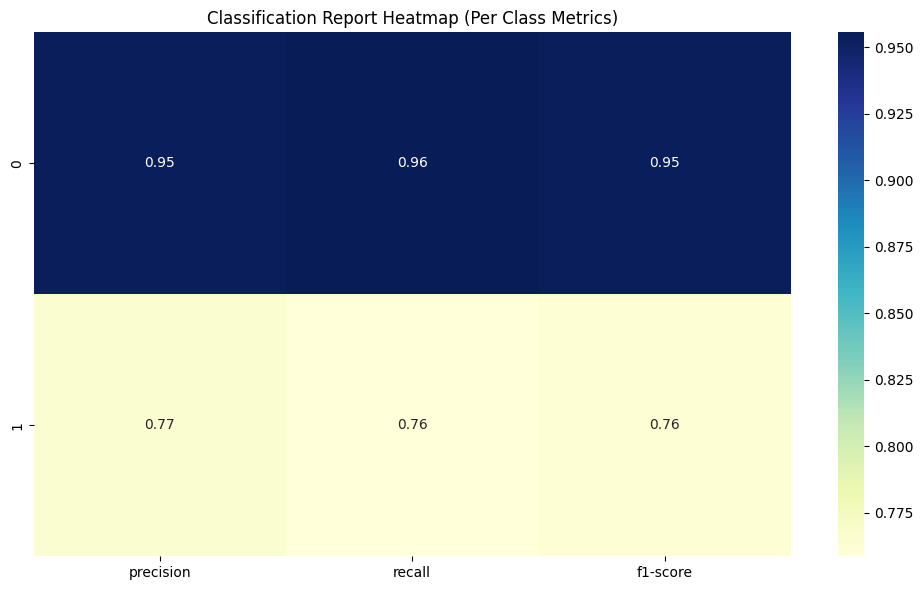

,precision,recall,f1-score,support
0,0.954098,0.955665,0.954881,609.000000
1,0.765217,0.758621,0.761905,116.000000
accuracy,0.924138,0.924138,0.924138,0.924138
macro avg,0.859658,0.857143,0.858393,725.000000
weighted avg,0.923877,0.924138,0.924005,725.000000


In [14]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


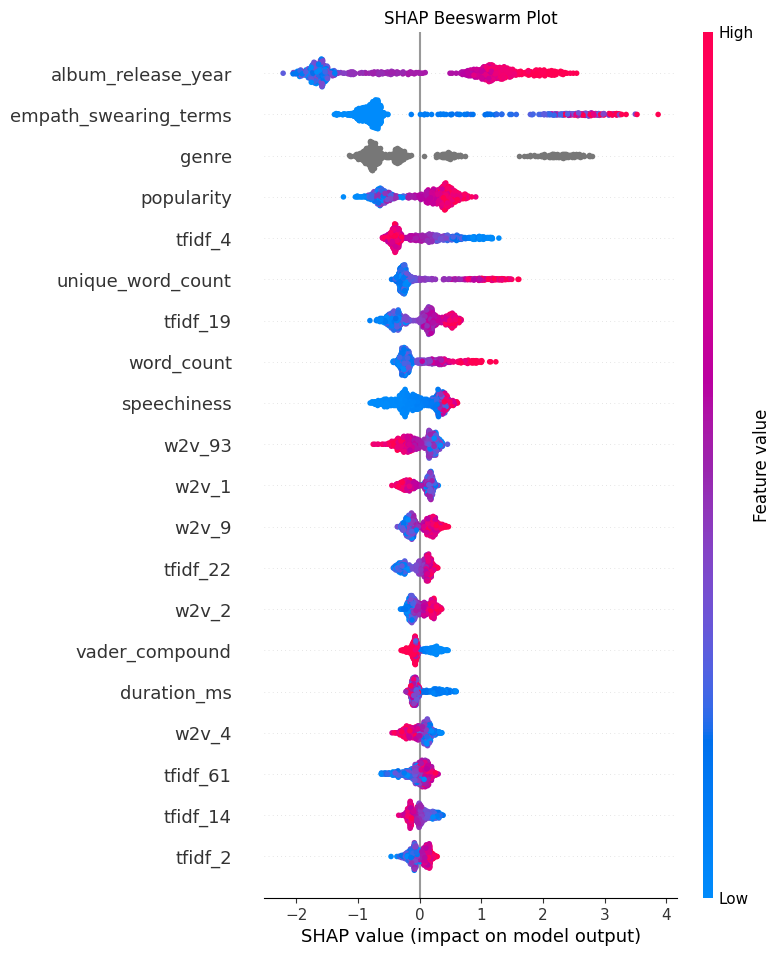

INFO: Generating feature importance bar plot...


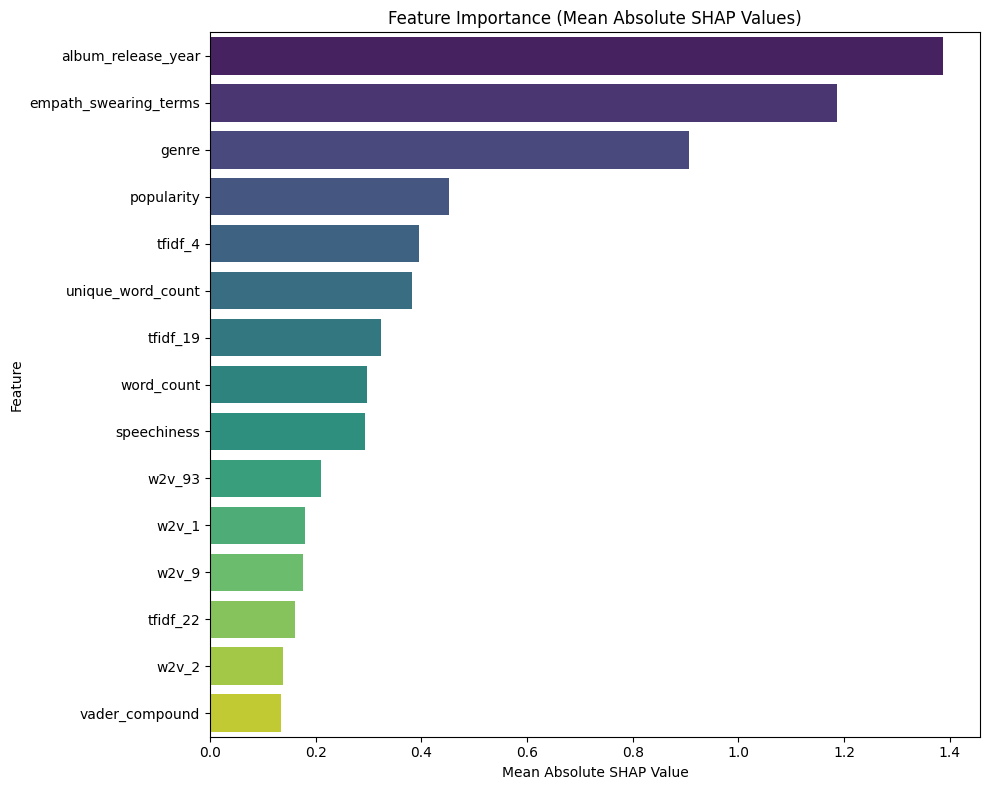

In [15]:
pipeline.perform_shap_analysis()

## Prediction with lyrics

In [16]:
target = 'explicit'
features = [ f for f in lyrics_features + tfidf_features + w2v_features + empath_features if f in df.columns ]

In [17]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [18]:
cat_features

['language', 'genre']

In [19]:
len(num_features)

412

In [20]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: explicit
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['tfidf_75',
                                                                    'w2v_24',
                                                                    'w2v_55',
                                                                    'empath_speaking',
                                                                    'tfidf_13',
                                                                    'empath_appearance',
                                                                    'empath_sexual',
                                                                    'w2v_2',
                                                                    'empath_hiking',
                                                                    'tfidf_40',
                                                                    't...
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['language',
                                                                    'genre'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x770a65df05b0>)])

In [21]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-21 00:27:33,312] A new study created in memory with name: catboost_explicit
[I 2024-12-21 00:28:38,165] Trial 4 finished with value: 0.9190912492679055 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.09035572118355584, 'l2_leaf_reg': 1.2518783545575831}. Best is trial 4 with value: 0.9190912492679055.
[I 2024-12-21 00:28:38,894] Trial 2 finished with value: 0.9104003056521819 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.025796177302152494, 'l2_leaf_reg': 2.5772104004902276}. Best is trial 4 with value: 0.9190912492679055.
[I 2024-12-21 00:29:50,762] Trial 7 finished with value: 0.9178055557711853 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.08702993004673594, 'l2_leaf_reg': 3.3267256842911297}. Best is trial 4 with value: 0.9190912492679055.
[I 2024-12-21 00:29:51,379] Trial 6 finished with value: 0.9141807503324998 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.03772878786111186, 'l2_leaf_r

INFO: Pipeline training completed.


In [22]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.923
1,F1 Score,0.922
2,Precision,0.921
3,Recall,0.923


INFO: Evaluating the model...


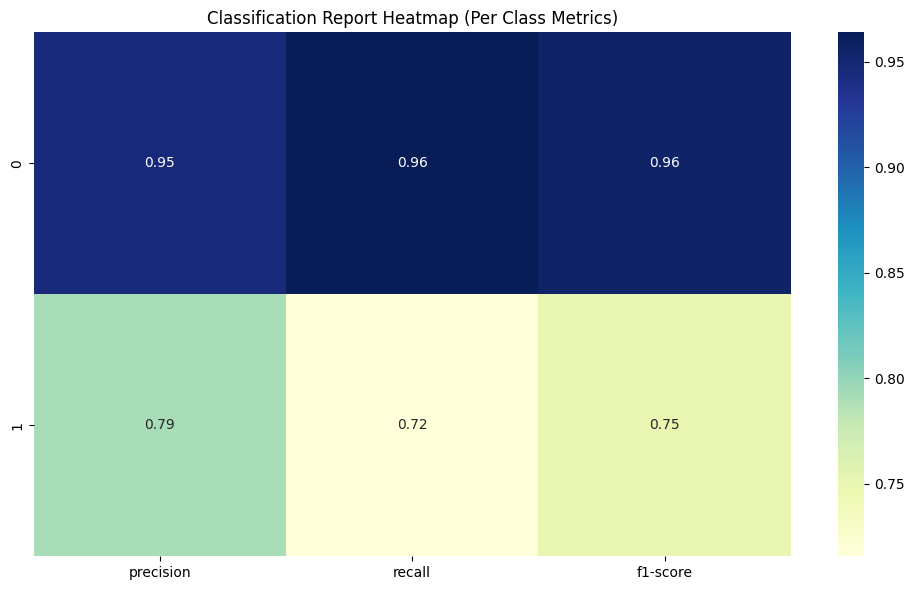

,precision,recall,f1-score,support
0,0.946774,0.963875,0.955248,609.000000
1,0.790476,0.715517,0.751131,116.000000
accuracy,0.924138,0.924138,0.924138,0.924138
macro avg,0.868625,0.839696,0.853190,725.000000
weighted avg,0.921767,0.924138,0.922589,725.000000


In [23]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


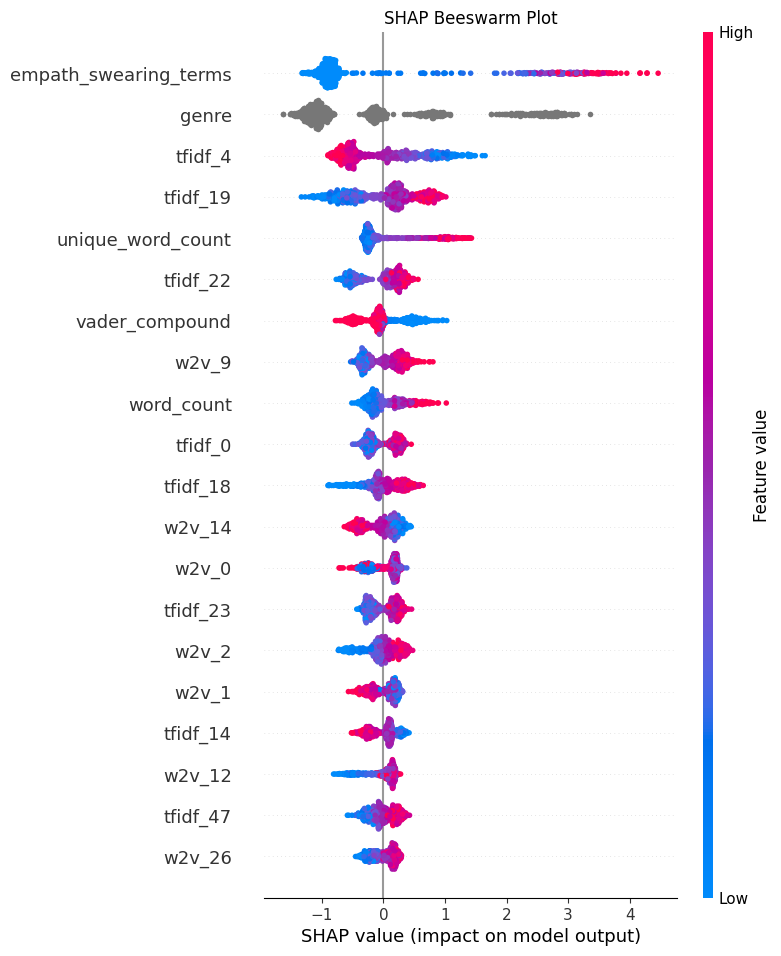

INFO: Generating feature importance bar plot...


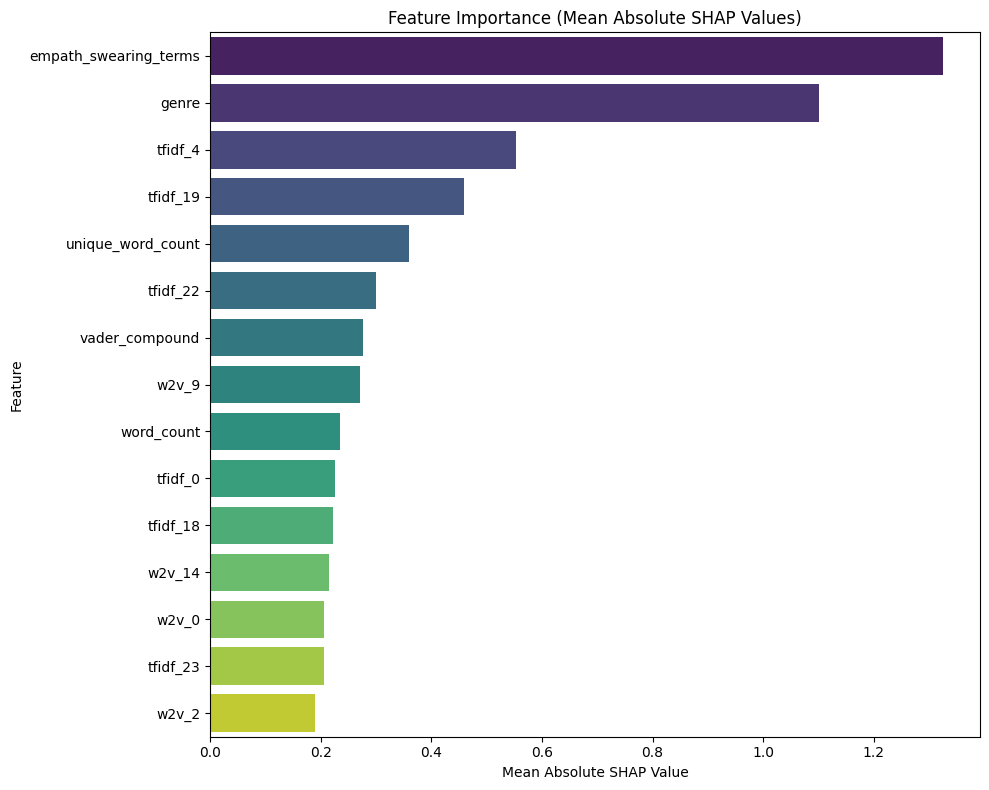

In [24]:
pipeline.perform_shap_analysis()

## Prediction with Spotify Features

In [25]:
target = 'explicit'
features = [ f for f in spotify_features if f in df.columns ]

In [26]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [27]:
cat_features

['key', 'mode', 'time_signature']

In [28]:
len(num_features)

12

In [29]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: explicit
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['popularity',
                                                                    'liveness',
                                                                    'valence',
                                                                    'album_release_year',
                                                                    'instrumentalness',
                                                                    'acousticness',
                                                                    'energy',
                                                                    'loudness',
                                                                    'speechiness',
                                                                    'danceab...
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['mode',
                                                                    'key',
                                                                    'time_signature'])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x770a646bb850>)])

In [30]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-21 00:32:41,772] A new study created in memory with name: catboost_explicit
[I 2024-12-21 00:32:49,746] Trial 4 finished with value: 0.8268470125572422 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.04685459370979904, 'l2_leaf_reg': 6.9149062010748565}. Best is trial 4 with value: 0.8268470125572422.
[I 2024-12-21 00:32:57,366] Trial 2 finished with value: 0.8275397848912724 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.029326175518067925, 'l2_leaf_reg': 7.987349571476962}. Best is trial 2 with value: 0.8275397848912724.
[I 2024-12-21 00:33:01,611] Trial 3 finished with value: 0.8568655293904113 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.09381428467191082, 'l2_leaf_reg': 7.099967957870632}. Best is trial 3 with value: 0.8568655293904113.
[I 2024-12-21 00:33:03,546] Trial 6 finished with value: 0.844099925778995 and parameters: {'iterations': 1000, 'depth': 6, 'learning_rate': 0.03786616109211476, 'l2_leaf_reg'

INFO: Pipeline training completed.


In [31]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.854
1,F1 Score,0.857
2,Precision,0.861
3,Recall,0.854


INFO: Evaluating the model...


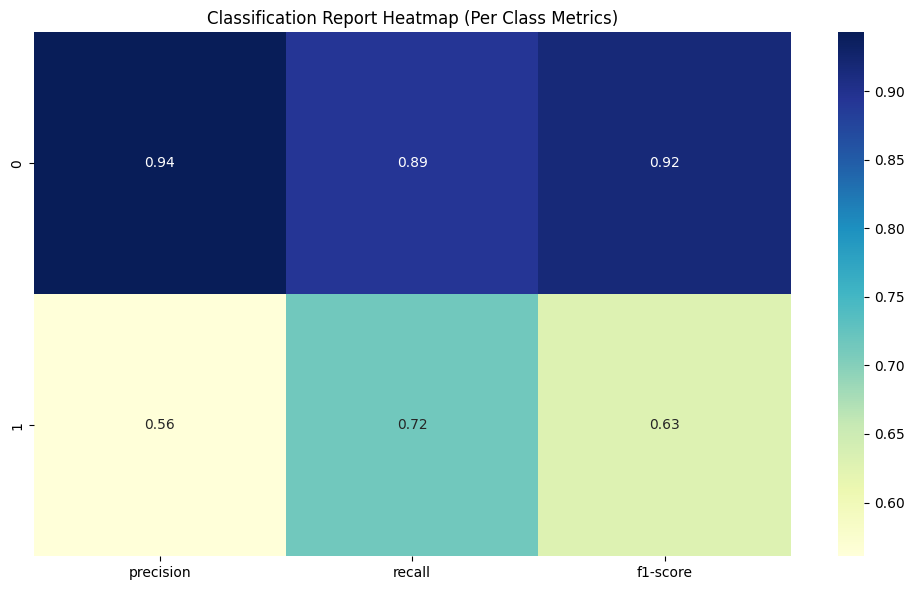

,precision,recall,f1-score,support
0,0.942808,0.893268,0.917369,609.000000
1,0.560811,0.715517,0.628788,116.000000
accuracy,0.864828,0.864828,0.864828,0.864828
macro avg,0.751809,0.804392,0.773079,725.000000
weighted avg,0.881688,0.864828,0.871196,725.000000


In [32]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


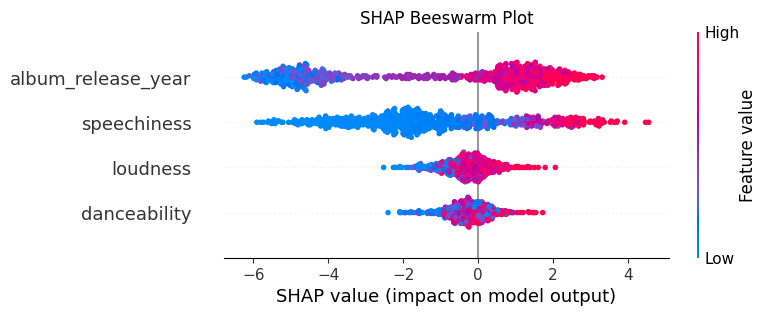

INFO: Generating feature importance bar plot...


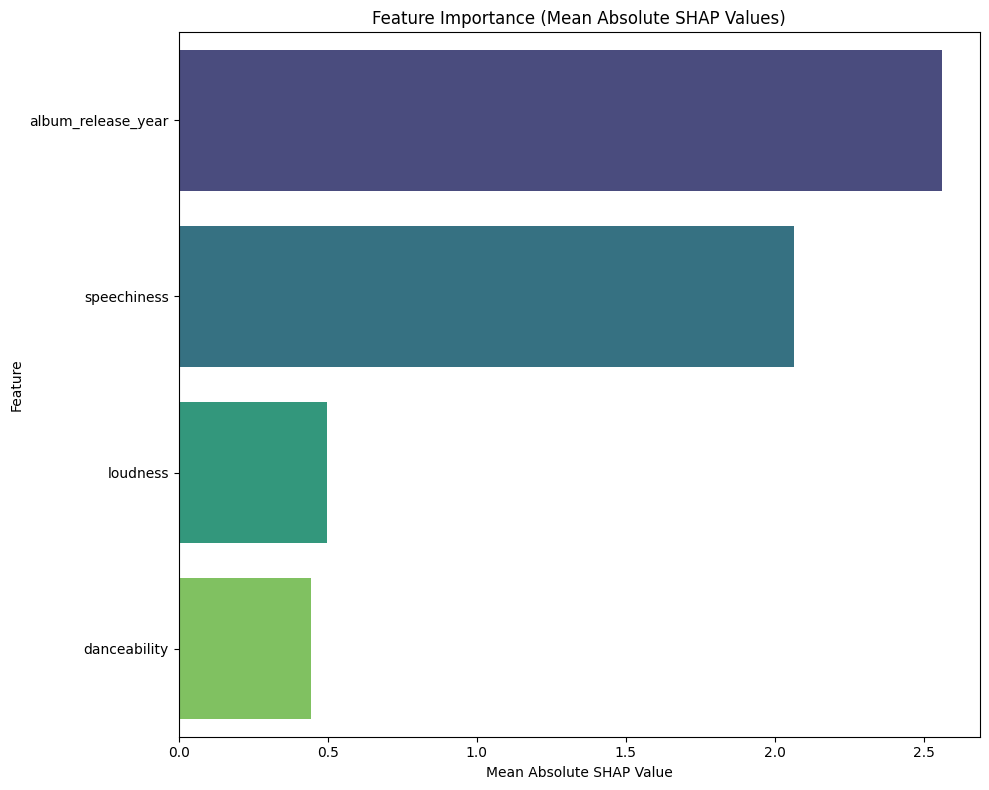

In [33]:
pipeline.perform_shap_analysis()

## Prediction with Audio Features

In [34]:
target = 'explicit'
features = [ f for f in audio_extracted_features if f in df.columns ]

In [35]:
cat_features = [ f for f in df[features].select_dtypes(include=['category', 'object']).columns if f != target ]
num_features = [ f for f in df[features].select_dtypes(include=[np.number]).columns if f != target ]

In [36]:
cat_features

[]

In [37]:
len(num_features)

34

In [38]:
pipeline = OptimalClassificationPipeline(
    df,
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    # cache_path="catboost_optuna.db"
)
pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: explicit
INFO: Setting up the pipeline with feature selection...
INFO: Setting up the pipeline with feature selection...


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['chroma_3',
                                                                    'mfcc_11',
                                                                    'chroma_7',
                                                                    'spectral_contrast_5',
                                                                    'mfcc_1',
                                                                    'mfcc_7',
                                                                    'chroma_1',
                                                                    'chroma_6',
                                                                    'chroma_11',
                                                                    'spectral_contrast_1',
                                                                    'mf...
                                                                                                  strategy='constant')),
                                                                                   ('ordinal',
                                                                                    OrdinalEncoder(dtype='object',
                                                                                                   handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   [])],
                                                    verbose_feature_names_out=False)),
                                 ('feature_selection',
                                  SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                                                  threshold='mean'))])),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x770a6271fc40>)])

In [39]:
pipeline.split()
pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-21 00:33:28,379] A new study created in memory with name: catboost_explicit
[I 2024-12-21 00:33:40,178] Trial 4 finished with value: 0.8118464598830475 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.07102076995096179, 'l2_leaf_reg': 2.9800919753918302}. Best is trial 4 with value: 0.8118464598830475.
[I 2024-12-21 00:33:40,821] Trial 7 finished with value: 0.7664414761689683 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.010156140729498817, 'l2_leaf_reg': 6.446329485637409}. Best is trial 4 with value: 0.8118464598830475.
[I 2024-12-21 00:33:51,174] Trial 2 finished with value: 0.8114884294659468 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.08289655360213395, 'l2_leaf_reg': 9.009618644552946}. Best is trial 4 with value: 0.8118464598830475.
[I 2024-12-21 00:33:51,811] Trial 6 finished with value: 0.8102834347718586 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.040309417809428524, 'l2_leaf_re

INFO: Pipeline training completed.


In [40]:
pipeline.model.training_results

,Metric,Score
0,Accuracy,0.828
1,F1 Score,0.823
2,Precision,0.820
3,Recall,0.828


INFO: Evaluating the model...


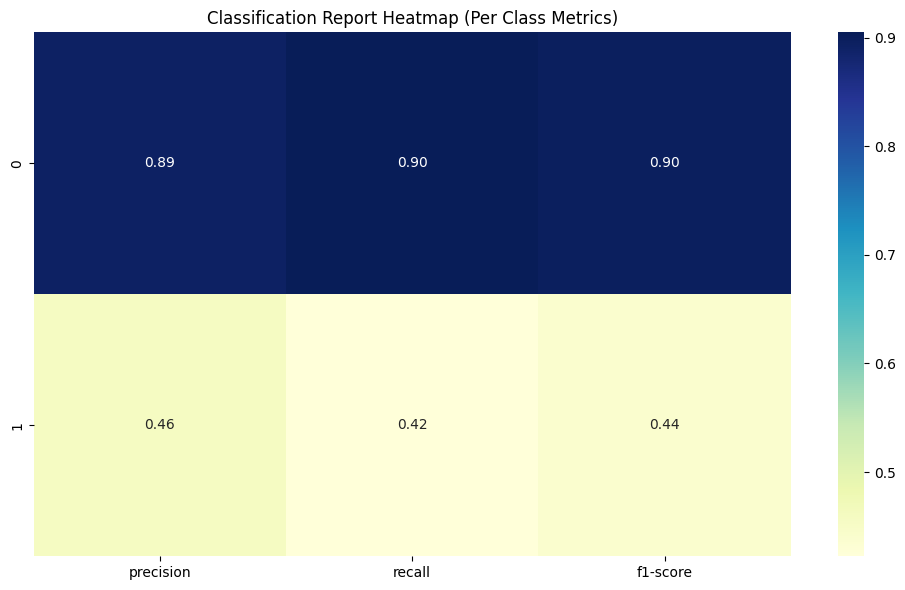

,precision,recall,f1-score,support
0,0.891586,0.904762,0.898126,609.000000
1,0.457944,0.422414,0.439462,116.000000
accuracy,0.827586,0.827586,0.827586,0.827586
macro avg,0.674765,0.663588,0.668794,725.000000
weighted avg,0.822203,0.827586,0.824739,725.000000


In [41]:
pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


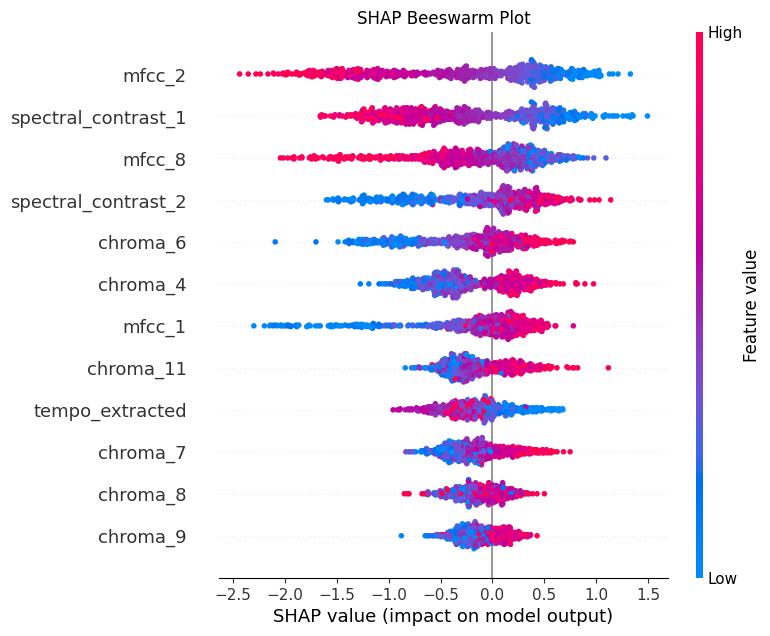

INFO: Generating feature importance bar plot...


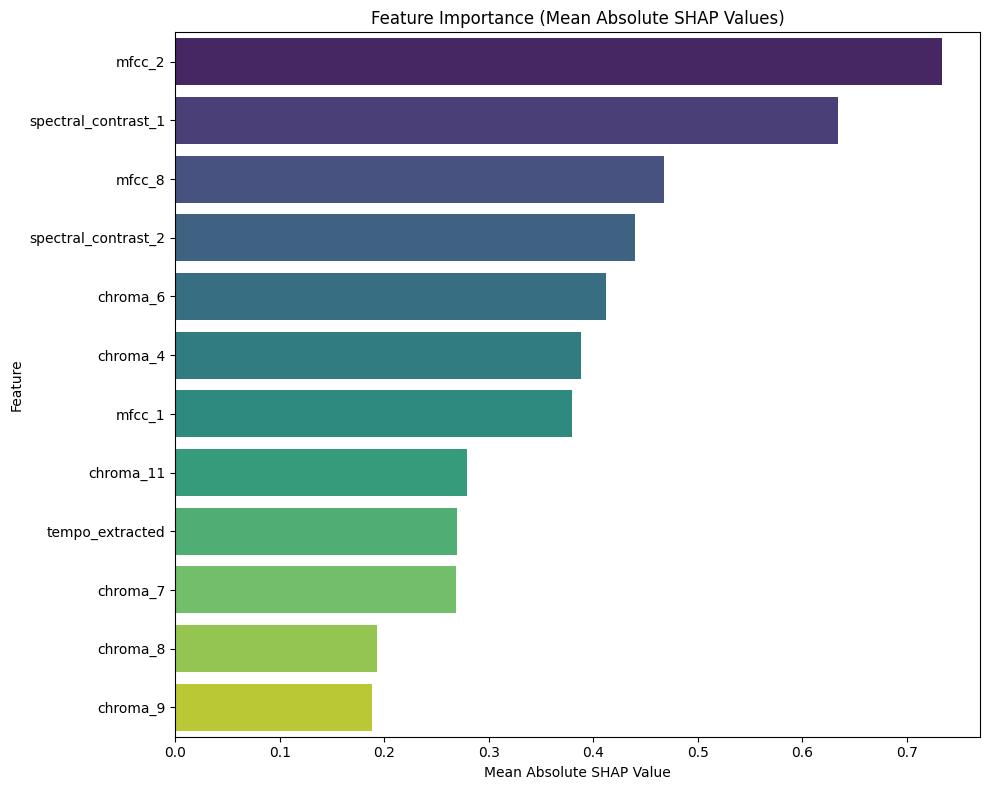

In [42]:
pipeline.perform_shap_analysis()

## Baseline

In [43]:
majority_model = MajorityBaselineModel()
majority_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = majority_model.predict(pipeline.X_test)
majority_model.evaluate(pipeline.y_test, y_pred)

,Score
Accuracy,0.840000
Precision,0.705600
Recall,0.840000
F1 Score,0.766957


In [44]:
random_model = RandomBaselineModel()
random_model.fit(pipeline.X_train, pipeline.y_train)
y_pred = random_model.predict(pipeline.X_test)
random_model.evaluate(pipeline.y_test, y_pred)

,Score
Accuracy,0.470345
Precision,0.706445
Recall,0.470345
F1 Score,0.539145


In [45]:
df.popularity.mean()

58.94283347141673

# Popularity vs. explicit content

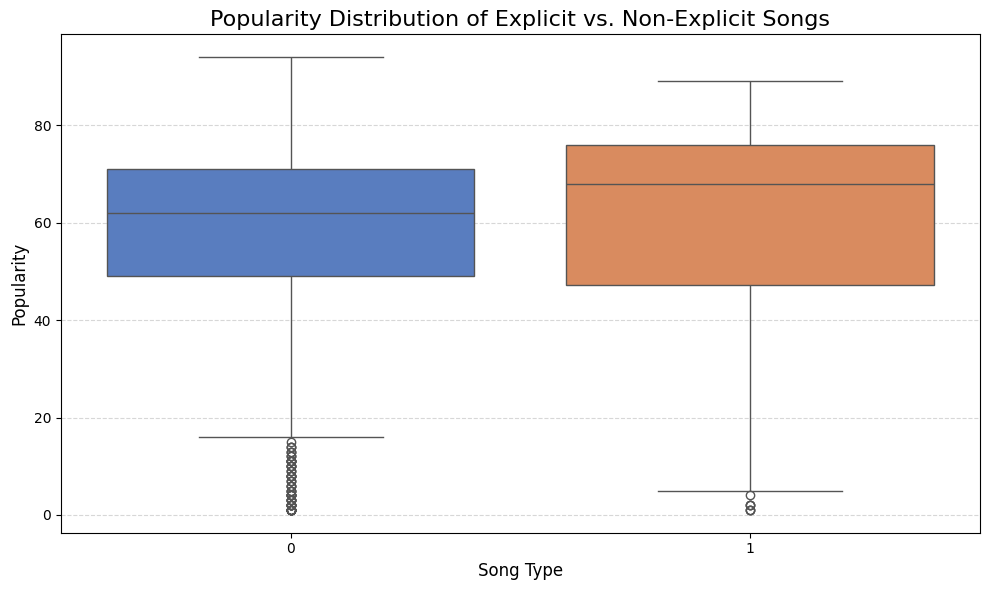

In [5]:
tmp_df = df.copy()


explicit_vs_popularity = tmp_df[['explicit', 'popularity']].copy()
explicit_vs_popularity['explicit_label'] = explicit_vs_popularity['explicit']

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='explicit_label', 
    y='popularity', 
    data=explicit_vs_popularity, 
    palette='muted'
)

plt.title('Popularity Distribution of Explicit vs. Non-Explicit Songs', fontsize=16)
plt.xlabel('Song Type', fontsize=12)
plt.ylabel('Popularity', fontsize=12)

plt.tight_layout()
plt.grid(visible=True, linestyle='--', alpha=0.5, axis='y')
plt.show()

In [6]:

def winsorize_series(series, lower_percentile=0.025, upper_percentile=0.975):
    lower_limit = np.percentile(series, lower_percentile * 100)
    upper_limit = np.percentile(series, upper_percentile * 100)
    return np.clip(series, lower_limit, upper_limit)

tmp_df['popularity_winsorized'] = winsorize_series(tmp_df['popularity'])

explicit_popularity = tmp_df.loc[tmp_df['explicit'] == '1', 'popularity_winsorized']
non_explicit_popularity = tmp_df.loc[tmp_df['explicit'] == '0', 'popularity_winsorized']

t_stat, t_pval = ttest_ind(explicit_popularity, non_explicit_popularity, equal_var=False)

u_stat, u_pval = mannwhitneyu(explicit_popularity, non_explicit_popularity, alternative='two-sided')

print(f"T-Test Results: t-statistic = {t_stat:.3f}, p-value = {t_pval:.3e}")
print(f"Mann-Whitney U Test Results: U-statistic = {u_stat:.3f}, p-value = {u_pval:.3e}")

T-Test Results: t-statistic = 2.020, p-value = 4.371e-02
Mann-Whitney U Test Results: U-statistic = 1024313.000, p-value = 2.509e-07


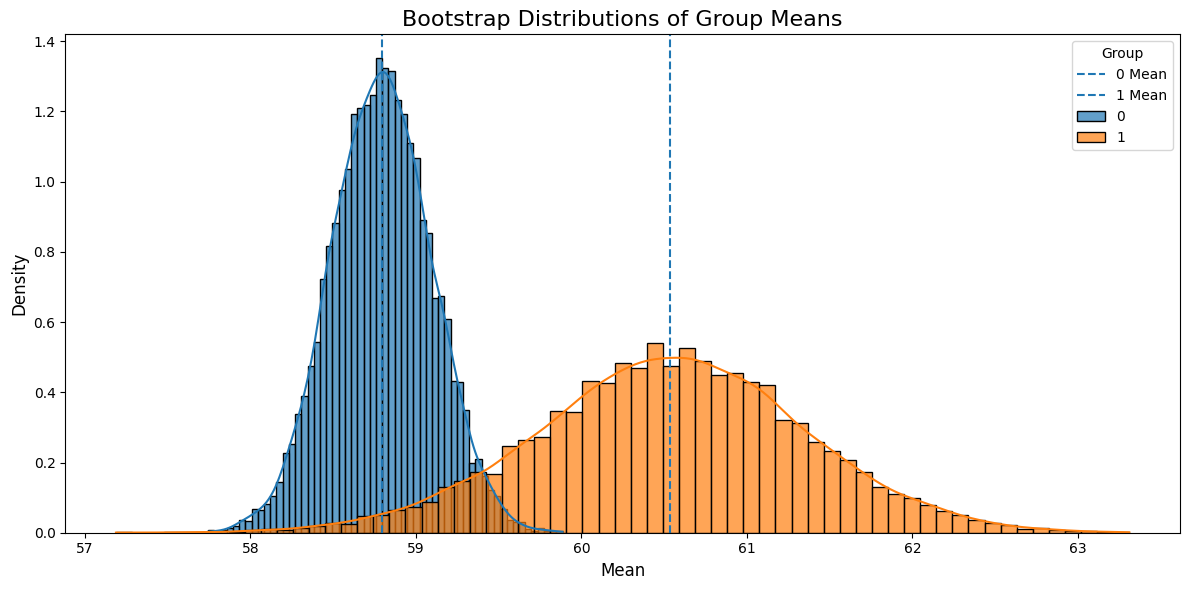

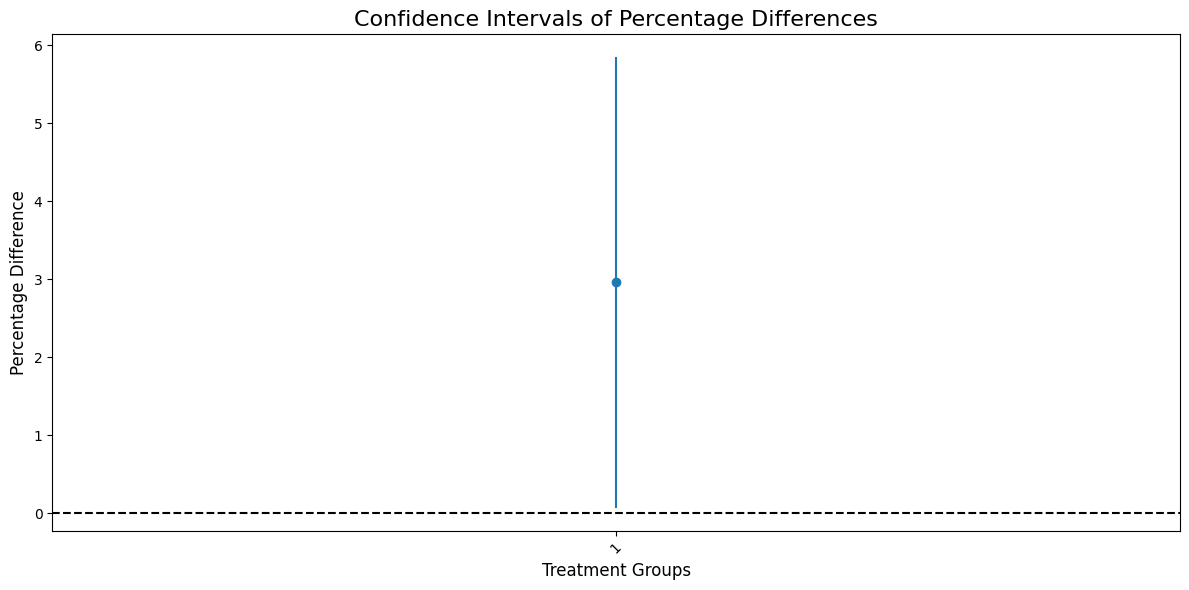

,control_group,treatment_group,pct_diff,pct_ci_lower,pct_ci_upper,abs_diff,abs_diff_ci_lower,abs_diff_ci_upper
0,0,1,2.96%,0.07%,5.85%,1.74,0.039069,3.440319


In [7]:
evaluator = BootstrapEvaluator(tmp_df, group_col="explicit", value_col="popularity_winsorized", control_group="0")
results = evaluator.evaluate(n_resamples=10000)
evaluator.plot_means_distribution()
evaluator.plot_interval()
evaluator.get_results_table()

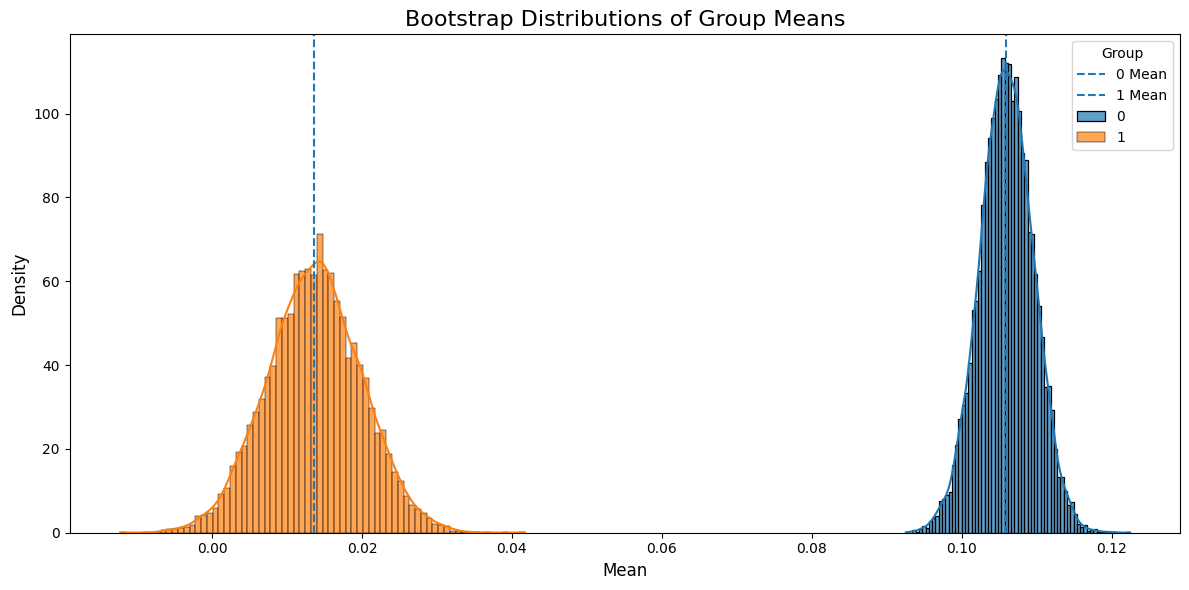

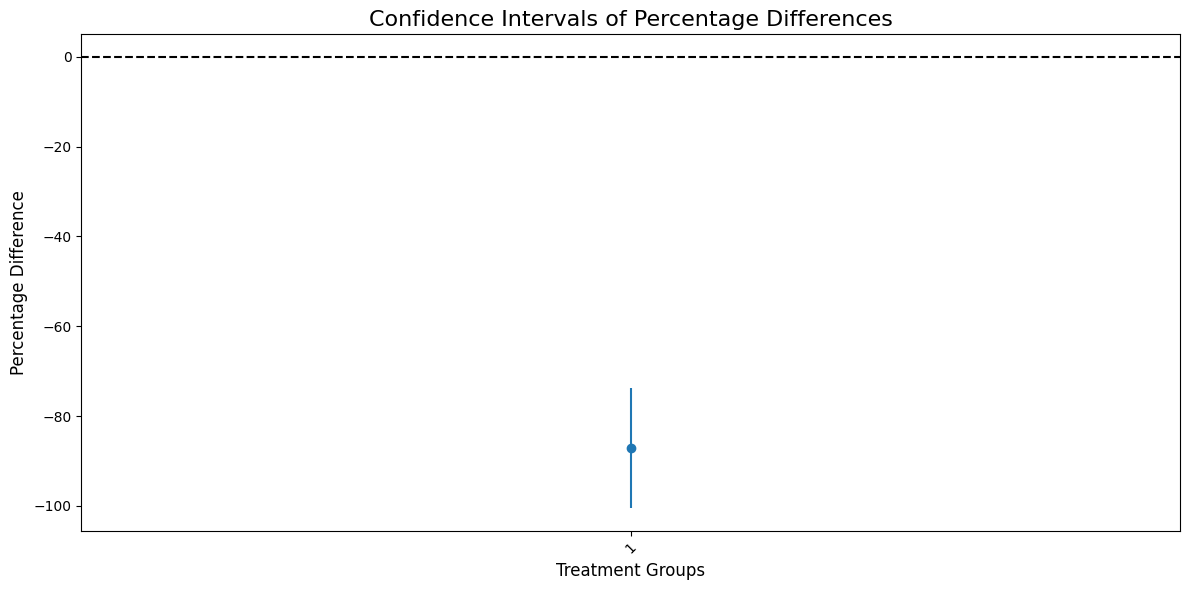

,control_group,treatment_group,pct_diff,pct_ci_lower,pct_ci_upper,abs_diff,abs_diff_ci_lower,abs_diff_ci_upper
0,0,1,-87.10%,-100.49%,-73.69%,-0.09,-0.106476,-0.078078


In [8]:
evaluator = BootstrapEvaluator(tmp_df, group_col="explicit", value_col="sentiment_polarity", control_group="0")
results = evaluator.evaluate(n_resamples=10000)
evaluator.plot_means_distribution()
evaluator.plot_interval()
evaluator.get_results_table()

In [10]:
tmp_df.groupby('explicit').sentiment_polarity.mean()

explicit
0    0.105958
1    0.013668
Name: sentiment_polarity, dtype: float64

In [11]:
(0.013668 - 0.105958) / 0.105958

-0.8710054927424074

In [63]:
pop = tmp_df[tmp_df.genre == 'pop'].copy()
pop.popularity = tmp_df.popularity.median()
pop.genre = 'median'
tmp_df = pd.concat([tmp_df, pop], axis=0)

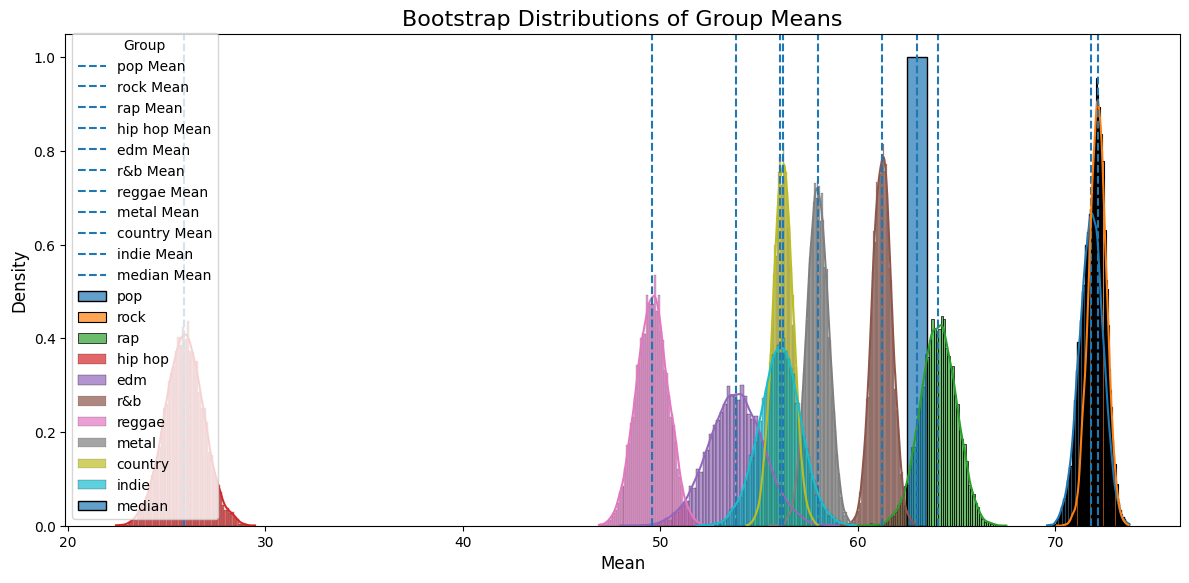

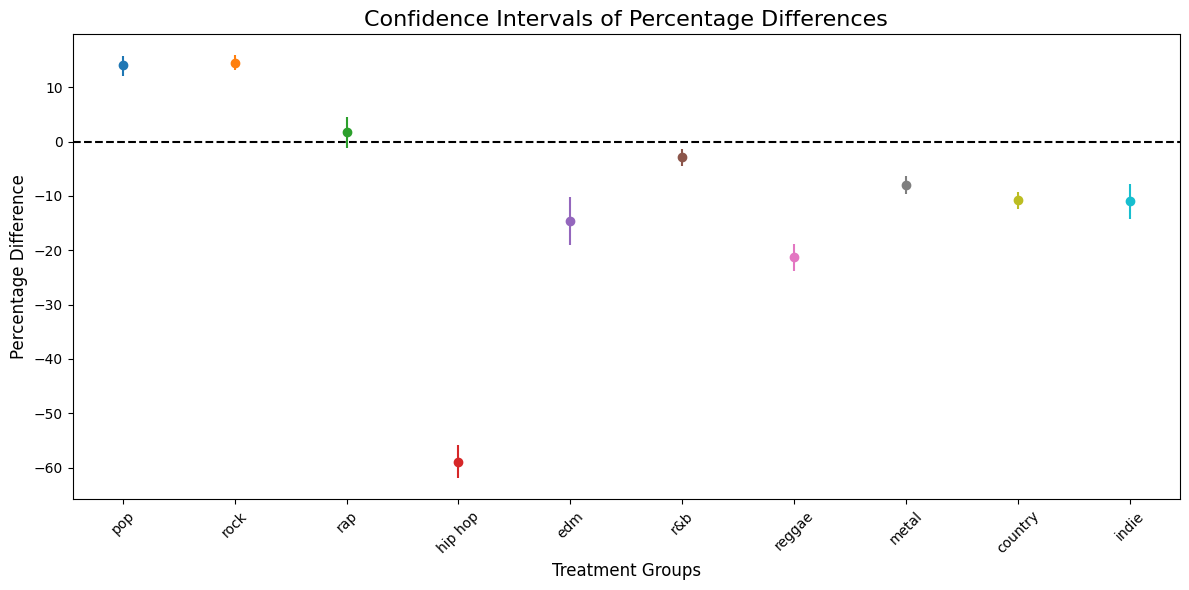

,control_group,treatment_group,pct_diff,pct_ci_lower,pct_ci_upper,abs_diff,abs_diff_ci_lower,abs_diff_ci_upper
0,median,pop,14.00%,12.14%,15.80%,8.82,7.648016,9.952447
1,median,rock,14.50%,13.12%,15.84%,9.14,8.266667,9.979368
2,median,rap,1.70%,-1.21%,4.51%,1.07,-0.761039,2.838961
3,median,hip hop,-58.90%,-61.94%,-55.81%,-37.11,-39.022321,-35.160714
4,median,edm,-14.57%,-18.97%,-10.12%,-9.18,-11.952153,-6.373206
5,median,r&b,-2.84%,-4.45%,-1.29%,-1.79,-2.806522,-0.813043
6,median,reggae,-21.30%,-23.80%,-18.83%,-13.42,-14.996212,-11.863636
7,median,metal,-7.98%,-9.67%,-6.33%,-5.03,-6.089744,-3.987073
8,median,country,-10.78%,-12.37%,-9.23%,-6.79,-7.793103,-5.812500
9,median,indie,-10.99%,-14.30%,-7.74%,-6.93,-9.011976,-4.874177


In [64]:
evaluator = BootstrapEvaluator(tmp_df, group_col="genre", value_col="popularity", control_group="median")
results = evaluator.evaluate(n_resamples=10000)
evaluator.plot_means_distribution()
evaluator.plot_interval()
evaluator.get_results_table()